Initial analysis while getting functionality up and running

In [1]:
from collections import defaultdict
import gzip
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import sys
import tqdm

from scipy.stats import ttest_ind

from arbitrary_signs import valid_language_exts
# Note there's a weird problem with arabic (ar) so remove
valid_language_exts = valid_language_exts[1:]

%matplotlib inline

In [2]:
def load_data(data_fp):
    with open(data_fp, "rb") as fp:
        data = pickle.load(fp)
    return data

In [3]:
dir_path = "/Users/benpeloquin/Data/projects/arbitrary_signs/outputs-100-10000-20190530/"
create_lang_file = lambda x: "{}_100_10000_dists.pickle".format(x)
all_language_fps = list(map(lambda x: (x, os.path.join(dir_path, create_lang_file(x))), valid_language_exts))

In [4]:
# Note (BP): slow running
all_data_files = {}
for lang, fp in tqdm.tqdm(all_language_fps):
    all_data_files[lang] = load_data(fp)

100%|██████████| 29/29 [02:16<00:00,  4.70s/it]


In [5]:
print(all_data_files["es"].keys())
print(all_data_files["es"][1].keys())
print(len(all_data_files["es"][1]["real_word_dists"]))

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])
dict_keys(['real_word_dists', 'real_vector_dists', 'random_word_dists', 'real_word_pairs', 'shuffle_idxs'])
10000


In [6]:
all_langs_corrs = defaultdict(lambda: defaultdict(list))
for lang in tqdm.tqdm(all_data_files.keys()):
    for batch in all_data_files[lang].keys():
        real_word_dists = all_data_files[lang][batch]["real_word_dists"]
        random_word_dists = all_data_files[lang][batch]["random_word_dists"]
        real_vector_dists = all_data_files[lang][batch]["real_vector_dists"]
        real_corrs = np.corrcoef(real_word_dists, real_vector_dists)[0][1]
        random_corrs = np.corrcoef(random_word_dists, real_vector_dists)[0][1]
        all_langs_corrs[lang]["real"].append(real_corrs)
        all_langs_corrs[lang]["random"].append(random_corrs)

100%|██████████| 29/29 [00:11<00:00,  2.52it/s]


In [7]:
def plot_hists(x_real, x_random, alphas=[0.6, 0.2], linestyle="dashed", title="", xlim=(-0.1, 0.1), ylim=(0, 30)):
    plt.axvline(np.mean(x_random), color="red", linestyle=linestyle)
    plt.axvline(np.mean(x_real), color="blue", linestyle=linestyle)
    plt.hist(x_random, color="red", alpha=alphas[1])
    plt.hist(x_real, color="blue", alpha=alphas[0])
    t = ttest_ind(x_real, x_random)
    plt.title("{} t({})={}, p={}".format(title, len(x_real), round(t[0], 4), round(t[1], 4)))
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    return plt

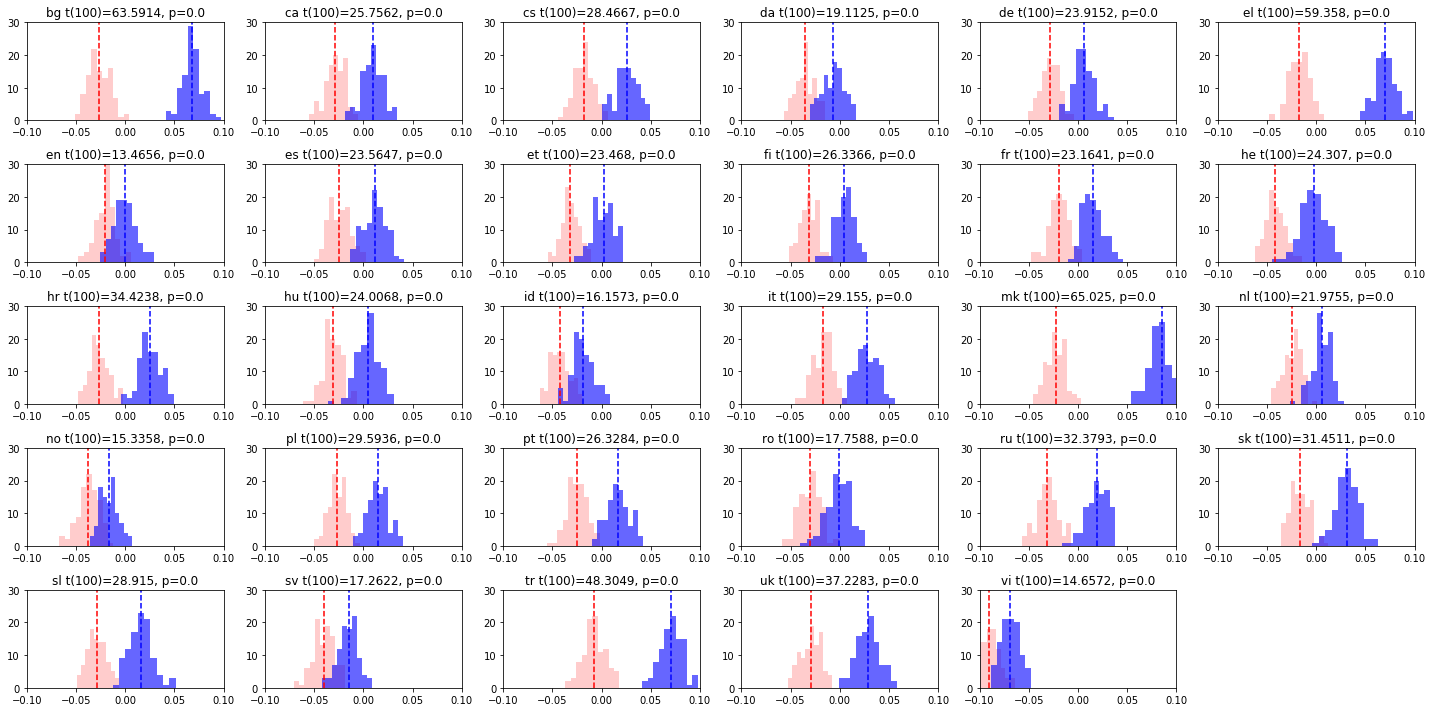

In [8]:
plt.figure(figsize=(20, 10))
n_languages = len(all_langs_corrs.keys())

for idx, lang in enumerate(all_langs_corrs.keys(), 1):
    plt.subplot(5, 6, idx)
    plot_hists(all_langs_corrs[lang]["real"], all_langs_corrs[lang]["random"], title=lang)
plt.tight_layout()

<module 'matplotlib.pyplot' from '/Users/benpeloquin/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py'>

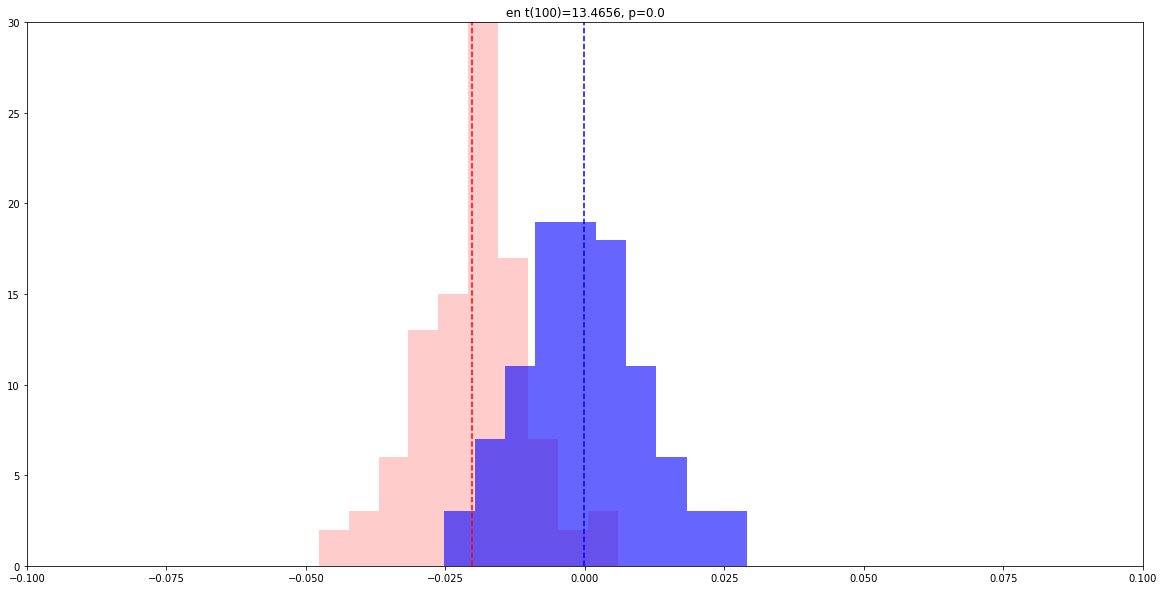

In [9]:
plt.figure(figsize=(20, 10))
plot_hists(all_langs_corrs["en"]["real"], all_langs_corrs["en"]["random"], title="en")

Odd that we have so many negative correlations for the permuted groups.

In [9]:
# all_data_files["en"][0]["real_word_pairs"]

In [10]:
def load_vectors(fp):
    gzip_fp = gzip.open(fp, "rb")
    n, d = map(int, gzip_fp.readline().split())
    data = {}
    for line in tqdm.tqdm(gzip_fp):
        tokens = line.decode("utf-8").rstrip().split(' ')
        data[tokens[0]] = np.array(list(map(float, tokens[1:])))
    return data

In [11]:
new_vecs_fp = "/Users/benpeloquin/Data/projects/arbitrary_signs/models/en-vectors.vec"
d_new = load_vectors(new_vecs_fp)

2000000it [03:16, 10171.19it/s]


In [12]:
old_model_fp = "/Users/benpeloquin/Data/projects/arbitrary_signs/outputs-100-10000-20190530/en_data.pickle"
with open(old_model_fp, 'rb') as fp:
    d_old = pickle.load(fp)

In [14]:
list(d_old['the']) == )

False

In [16]:
list(zip(d_old['the'], list(d_new['the'])))

[(-0.0324474, -0.0517),
 (-0.0462027, 0.074),
 (-0.00872643, -0.0131),
 (0.0993624, 0.0447),
 (0.0146613, -0.0343),
 (-0.0198258, 0.0212),
 (-0.0810911, 0.0069),
 (-0.0362278, -0.0163),
 (0.0445008, -0.0181),
 (0.0401815, -0.002),
 (-0.0198814, -0.1021),
 (-0.117326, 0.0059),
 (0.0906365, 0.0257),
 (-0.0304146, -0.0026),
 (-0.0319765, -0.0586),
 (-0.037376, -0.0378),
 (-0.0248697, 0.0163),
 (-0.00993326, 0.0146),
 (0.00173625, -0.0088),
 (0.071948, -0.0176),
 (-0.0833905, -0.0085),
 (0.0381676, -0.0078),
 (-0.114113, -0.0183),
 (-0.0287737, 0.0088),
 (-0.0665892, 0.0013),
 (-0.0365456, -0.0938),
 (-0.000624522, 0.0139),
 (0.00978774, 0.0149),
 (0.0282418, -0.0394),
 (0.0310399, -0.0294),
 (-0.0772521, 0.0094),
 (0.0755238, -0.0252),
 (-0.0527877, -0.0104),
 (0.122521, -0.2213),
 (-0.0138329, -0.0229),
 (-0.0879198, -0.0089),
 (0.00357867, -0.0322),
 (-0.0593036, 0.0822),
 (0.0416396, 0.0021),
 (-0.0588169, 0.0282),
 (0.0266258, 0.0072),
 (-0.00114942, -0.0091),
 (-0.0418562, -0.0352),


In [17]:
set(d_old.keys()) == set(d_new.keys())

False

In [21]:
list(zip(set(d_old.keys()), set(d_new.keys())))[:400]

[('gordonsville', 'Bulmahn'),
 ('graveyards', 'chlorofluorocarbon'),
 ('pairc', 'ifE'),
 ('reflex', 'numerary'),
 ('melia', 'Animators'),
 ('dinas', '19439'),
 ('artifacting', 'unmoored'),
 ('peces', 'distriubtion'),
 ('whitechapel', 'Bldr'),
 ('runciman', 'solium'),
 ('panis', 'skiathlon'),
 ('rosny', 'group.Table'),
 ('ionesco', 'TouchBistro'),
 ('kittyhawks', 'Dubi'),
 ('daryl', 'deadYou'),
 ('genia', '3-of-3'),
 ('gaétan', '2F20smoney.com'),
 ('pupil', 'versatile-blogger-award.html'),
 ('braque', 'Cosby'),
 ('schönen', 'Earning'),
 ('fiona', 'uhhh'),
 ('uhhh', 'Moidu'),
 ('overdoses', 'November.So'),
 ('forumup', 'violence.One'),
 ('supposing', '.Library'),
 ('sfh', '3-peat'),
 ('ngày', 'Hand-Made'),
 ('betweens', 'devx'),
 ('gravy', 'e-communication'),
 ('committee', 'users.Here'),
 ('property', 'hyperdunk'),
 ('giardia', 'InformationServices'),
 ('rony', 'Excised'),
 ('porcia', 'AskNature'),
 ('kloss', 'FHU'),
 ('introduceddate', '388,033Products'),
 ('morishima', 'Petersbourg'),